In [1]:
import numpy as np
import torch.nn.functional as F
from matplotlib import pyplot as plt
import tqdm
import json

import importlib
import mystuff
importlib.reload(mystuff)

<module 'mystuff' from '/home/luca/projects/nttn/mystuff.py'>

In [2]:
model_names = ['model0', 'model6', 'model10']
ranks = mystuff.logspace_int(start=16, end=800, n=32)
results = {
    'ranks': ranks,
}

In [3]:
for model_name in model_names:
    print(f'starting {model_name}')
    model = mystuff.MnistFCNet(name=model_name, seed=0)
    model.init_model(activation=F.relu, dropout=0)
    model.init_data_loader(batch_size=64)
    model.load_from_file()

    print('running base benchmarks... ', end='')
    base_loss, base_acc = model.score()
    result = {
        'base_loss': base_loss,
        'base_acc': base_acc,
    }
    print('DONE')

    print('computing svd... ', end='')
    W = model.copy_weights_of_interest()
    u, s, vt = np.linalg.svd(W)
    U = u @ np.diag(s)
    V = vt
    print('DONE')

    print('computing low-rank scores')
    losses = []
    accs = []
    def compute_svd_lowrank_score(rank):
        Ur = U[:,:rank]
        Vr = V[:rank,:]
        model.exchange_woi_with_factorization(Ur, Vr)
        return model.score()
    for loss, acc in tqdm.tqdm(map(compute_svd_lowrank_score, ranks), total=len(ranks)):
        losses.append(loss)
        accs.append(acc)
    result['losses'] = losses
    result['accs'] = accs
    results[model_name] = result
    print('DONE', end='\n\n')

json.dump(results, open('svd_compression_results.json', 'w'))

starting model0
running base benchmarks... DONE
computing svd... DONE
computing low-rank scores


100%|██████████| 32/32 [02:35<00:00,  4.85s/it]


DONE

starting model6
running base benchmarks... DONE
computing svd... DONE
computing low-rank scores


100%|██████████| 32/32 [02:08<00:00,  4.03s/it]


DONE

starting model10
running base benchmarks... DONE
computing svd... DONE
computing low-rank scores


100%|██████████| 32/32 [01:57<00:00,  3.66s/it]

DONE



In [ ]:
results = json.load(open('svd_compression_results.json', 'r'))

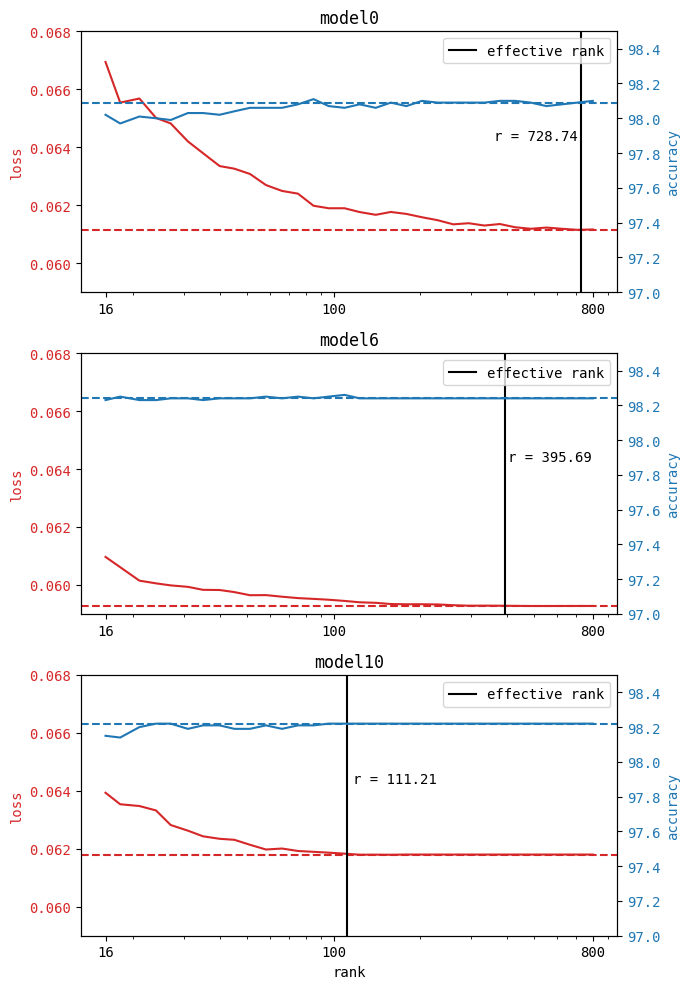

In [19]:
ranks = np.array(results['ranks'])

plt.rcParams["font.family"] = "monospace"
fig, ax = plt.subplots(3, 1)

for i, model_name in enumerate(model_names):
    base_acc = np.array(results[model_name]['base_acc'])
    accs = np.array(results[model_name]['accs'])
    base_loss = np.array(results[model_name]['base_loss'])
    losses = np.array(results[model_name]['losses'])

    ax[i].set_title(model_name)

    if i == len(ax) - 1: ax[i].set_xlabel('rank')
    ax[i].set_xscale('log')
    ax[i].set_xticks([ranks[0], 100, ranks[-1]])
    ax[i].set_xticklabels([ranks[0], 100, ranks[-1]])

    color = 'tab:red'
    ax[i].set_ylabel('loss', color=color)
    ax[i].set_ylim((0.059, 0.068))
    ax[i].plot(ranks, losses, color=color)
    ax[i].tick_params(axis='y', labelcolor=color)
    ax[i].axhline(base_loss, color=color, ls='--')

    effective_ranks = [728.74, 395.69, 111.21]
    effrk_ha = ['right', 'left', 'left']
    effrk_xoff = [-20, 10, 5]
    ax[i].axvline(effective_ranks[i], color='black', label='effective rank')
    effrk_ha = ['right', 'left', 'left']
    effrk_xoff = [-20, 10, 5]
    ax[i].text(effective_ranks[i] + effrk_xoff[i], 0.6, f'r = {effective_ranks[i]}', 
               color='black', transform=ax[i].get_xaxis_transform(), ha=effrk_ha[i], va='center')
    ax[i].legend(loc='upper right')

    axtwin = ax[i].twinx()
    color = 'tab:blue'
    axtwin.set_ylabel('accuracy', color=color)
    axtwin.set_ylim((97, 98.5))
    axtwin.plot(ranks, accs, color=color)
    axtwin.tick_params(axis='y', labelcolor=color)
    axtwin.axhline(base_acc, color=color, ls='--')

fig.set_size_inches(7, 10)
fig.tight_layout()
plt.savefig('svd_compression.png')
plt.show()